In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem
import XAIChem

pio.templates.default = "plotly_white"

In [15]:
# Load data sets
esol_df = pd.read_csv("../../data/ESOL/ESOL.csv")
attributions_functional_groups = pd.read_json("../../data/ESOL/attribution_no_mean.json").drop(
    columns=["time_SME", "time_HN_value", "time_Shapley_value"]
)
attributions_brics = pd.read_json("../../data/ESOL/attribution_brics_no_mean.json").drop(
    columns=["time_SME", "time_HN_value", "time_Shapley_value"]
)

In [6]:
# Load trained models
model, config = XAIChem.models.PreBuildModels.rgcnWuEtAll("../scripts/esol_reproduction.yaml", ["seed"], model_id=0)

paths = [
    f"../../data/ESOL/trained_models/ESOL_rgcn_model_{model_id}_early_stop.pt"
    for model_id in range(10)
]

models = XAIChem.loadModels(model, paths)

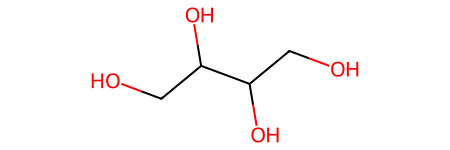

In [7]:
smiles = 'OCC(O)C(O)CO'
rdmol = Chem.MolFromSmiles(smiles)
graph = XAIChem.createDataObjectFromRdMol(rdmol, np.inf)

rdmol

# Predict solubility of Erythritol

In [12]:
experimental_solubility = esol_df.query("smiles == @smiles").ESOL.iloc[0]
predicted_solubility = XAIChem.predict(graph, models).item()

print(f"{experimental_solubility = }")
print(f"{predicted_solubility = }")

experimental_solubility = 0.7
predicted_solubility = 0.4321858882904053


The predicted solubility is not equal to the experimental solubility of the data set. This difference
could be explained using different attribution techniques (i.e. SME, Shapley value and HN value). From 
chemical theory it is known that hydroxyl group improve the solubility while apolar carbon chains are 
porly soluble. Therefore it is expected that the hydroxyl groups have a positive attribution while the 
carbon chain has a negative or slightly positive attribution.

# Explain prediction

In [31]:
explanation = attributions_functional_groups.query("molecule_smiles == @smiles").copy()
explanation["atom_ids"] = explanation.atom_ids.apply(tuple)

sme_explanation = explanation[["atom_ids", "SME"]].set_index("atom_ids").SME.round(2).to_dict()
HN_explanation = explanation[["atom_ids", "HN_value"]].set_index("atom_ids").HN_value.round(2).to_dict()
Shapley_explanation = explanation[["atom_ids", "Shapley_value"]].set_index("atom_ids").Shapley_value.round(2).to_dict()

### SME

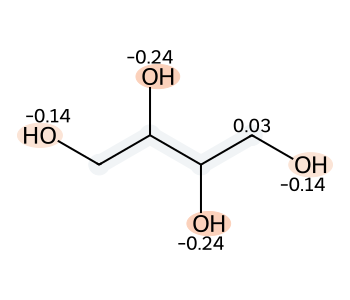

In [32]:
XAIChem.showMolecule(rdmol, atoms_highlight_values=sme_explanation)

### Shapley

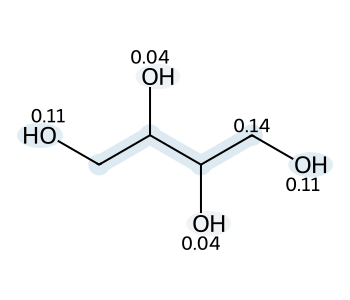

In [34]:
XAIChem.showMolecule(rdmol, atoms_highlight_values=Shapley_explanation)

### HN_value

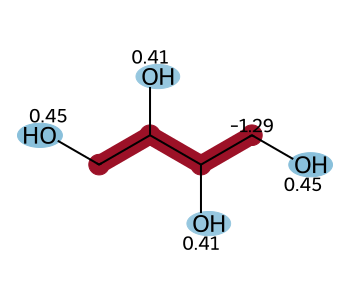

In [35]:
XAIChem.showMolecule(rdmol, atoms_highlight_values=HN_explanation)

Both SME and Shapley attributions are in conflict with chemical intuition and could explain why the model predicts a 
to long solubility. However, the HN attributions do result chemical correct attribution methods. This raises the question 
wheter the HN explanation is incorrect and the incorrect prediction can be explained by the Shapley and SME attributions,
or the HN explanation is correct and the failure of the model is due to another reason.